## License 

Copyright 2017 Patrick Hall and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

#### Python imports

In [1]:
# h2o Python API with specific classes
import h2o 
from h2o.estimators.gbm import H2OGradientBoostingEstimator

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling

pd.options.display.max_columns = 999 # enable display of all columns in notebook

# plotting functionality
import matplotlib.pyplot as plt
import seaborn as sns

import shap # Python Shapley value package

# display plots in notebook
%matplotlib inline

/home/patrickh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### Start h2o

In [2]:
h2o.init(max_mem_size='2G')       # start h2o
h2o.remove_all()                  # remove any existing data structures from h2o memory

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_201"; Java(TM) SE Runtime Environment (build 1.8.0_201-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpl3mfxavo
  JVM stdout: /tmp/tmpl3mfxavo/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmpl3mfxavo/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,6 days
H2O cluster name:,H2O_from_python_patrickh_mh0r6r
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005.

Because h2o accepts both numeric and character inputs, some variables will be recoded into more transparent character values.

#### Import data and clean

In [3]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

In [4]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID', 'AGE', 'EDUCATION', 'SEX', 'MARRIAGE', 'LIMIT_BAL']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Helper function for recoding values in the UCI credict card default data

In [5]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        H2OFrame with recoded values.
        
    """
    
    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption (-2)', -1:'pay duly (-1)', 0:'use of revolving credit (0)', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}
    
    # recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            
                
    return h2o.H2OFrame(frame)

data = recode_cc_data(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Ensure target is handled as a categorical variable

In [6]:
data[y] = data[y].asfactor() 

#### Display descriptive statistics

In [7]:
data.describe()

Rows:30000
Cols:25




,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
type,int,int,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,1.0,10000.0,,,,21.0,,,,,,,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,
mean,15000.5,167484.32266666667,,,,35.48549999999987,,,,,,,51223.330899999935,49179.0751666667,47013.15479999978,43262.94896666669,40311.4009666666,38871.76040000009,5663.580500000006,5921.1635,5225.681500000008,4826.076866666684,4799.3876333333155,5215.502566666679,
maxs,30000.0,1000000.0,,,,79.0,,,,,,,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,
sigma,8660.398374208891,129747.66156720246,,,,9.217904068090172,,,,,,,73635.86057552964,71173.76878252838,69349.38742703681,64332.856133916415,60797.1557702648,59554.10753674574,16563.280354025763,23040.87040205722,17606.961469803107,15666.159744031986,15278.305679144814,17777.465775435325,
zeros,0,0,,,,0,,,,,,,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,20000.0,female,university,married,24.0,2 month delay,2 month delay,pay duly (-1),pay duly (-1),no consumption (-2),no consumption (-2),3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2.0,120000.0,female,university,single,26.0,pay duly (-1),2 month delay,use of revolving credit (0),use of revolving credit (0),use of revolving credit (0),2 month delay,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3.0,90000.0,female,university,single,34.0,use of revolving credit (0),use of revolving credit (0),use of revolving credit (0),use of revolving credit (0),use of revolving credit (0),use of revolving credit (0),29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


## 2. Train an H2O GBM classifier

#### Split data into training and test sets for early stopping

In [8]:
# split into training and validation
train, test = data.split_frame([0.7], seed=12345)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21060, columns = 25
Test data rows = 8940, columns = 25


#### Train h2o GBM classifier

In [9]:
# initialize GBM model
model = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                     max_depth=4,           # trees can have maximum depth of 4
                                     sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.9,   # use 90% of variables in each iteration (tree)
                                     stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                     seed=12345)            # for reproducibility

# train a GBM model
model.train(y=y, x=X, training_frame=train, validation_frame=test)

# print AUC
print('GBM Test AUC = %.4f' % model.auc(valid=True))

# uncomment to see model details
# print(model) 

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.7714


#### Display Shapley variable importance

/home/patrickh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


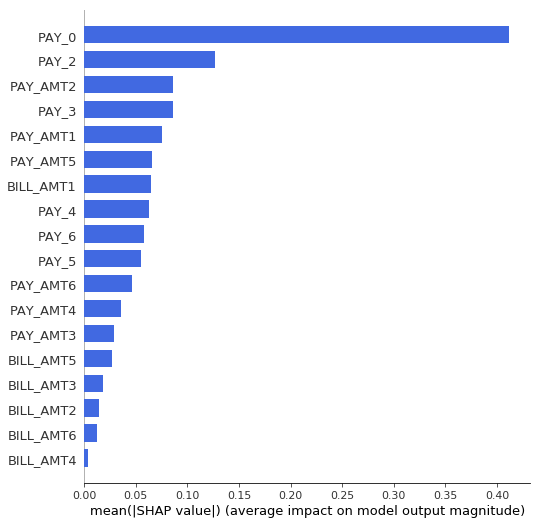

In [10]:
contributions = model.predict_contributions(test)
contributions_matrix = contributions.as_data_frame().as_matrix()
shap_values = contributions_matrix[:,:-1]
shap.summary_plot(shap_values, X, plot_type='bar', color='royalblue')

## 3. Conduct residual analysis to debug model

#### Bind model predictions onto test data 

In [11]:
yhat = 'p_DEFAULT_NEXT_MONTH'
preds1 = model.predict(test).drop(['predict', 'p0'])
preds1.columns = [yhat]
test_yhat = test.cbind(preds1[yhat])

gbm prediction progress: |████████████████████████████████████████████████| 100%


#### Calculate deviance residuals for binomial classification

In [12]:
# use Pandas for adding columns and plotting
test_yhat = test_yhat.as_data_frame()
test_yhat['s'] = 1
test_yhat.loc[test_yhat['DEFAULT_NEXT_MONTH'] == 0, 's'] = -1
test_yhat['r_DEFAULT_NEXT_MONTH'] = test_yhat['s'] * np.sqrt(-2*(test_yhat[y]*np.log(test_yhat[yhat]) +
                                                                 ((1 - test_yhat[y])*np.log(1 - test_yhat[yhat]))))
test_yhat = test_yhat.drop('s', axis=1)

#### Sort data by residuals and display data and residuals

In [13]:
test_yhat = test_yhat.sort_values(by='r_DEFAULT_NEXT_MONTH', ascending=False).reset_index(drop=True)
test_yhat

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
0,6933,500000,male,graduate school,single,37,pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),4331,60446,30592,154167,13410,25426,60446,30594,150843,163881,25426,39526,1,0.048142,2.463165
1,22505,260000,female,university,single,33,pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),use of revolving credit (0),5188,12357,28656,7497,7685,15434,13000,29022,7500,27769,12000,6200,1,0.048142,2.463165
2,2561,310000,female,graduate school,single,32,no consumption (-2),no consumption (-2),no consumption (-2),no consumption (-2),no consumption (-2),no consumption (-2),20138,8267,65993,8543,1695,750,8267,66008,8543,1695,750,7350,1,0.056123,2.400086
3,11745,220000,male,graduate school,single,51,pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),20730,-270,53895,-105,20895,20835,0,54165,0,21000,20940,33460,1,0.056634,2.396310
4,25772,350000,female,graduate school,married,33,use of revolving credit (0),pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),82964,68532,17926,17966,30741,31088,68940,18018,18058,30897,31244,88461,1,0.061981,2.358360
5,29294,50000,male,graduate school,single,25,pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),pay duly (-1),9716,25045,15180,6964,7604,2173,25045,15522,6964,7604,2173,6586,1,0.061981,2.358360
6,25692,330000,female,graduate school,single,42,no consumption (-2),no consumption (-2),no consumption (-2),no consumption (-2),no consumption (-2),no consumption (-2),565,20650,15360,0,12923,1816,20650,15360,0,12923,1816,17050,1,0.062990,2.351502
7,8339,480000,male,graduate school,married,58,no consumption (-2),no consumption (-2),no consumption (-2),no consumption (-2),no consumption (-2),no consumption (-2),24610,-310,148544,18791,5909,68988,4,149654,18885,5940,69337,200655,1,0.066306,2.329584
8,15482,150000,male,graduate school,married,37,no consumption (-2),no consumption (-2),no consumption (-2),no consumption (-2),no consumption (-2),no consumption (-2),22109,10876,10268,5872,3068,2181,10943,10273,5978,3068,2181,3242,1,0.067178,2.323969
9,3016,350000,male,graduate school,married,38,no consumption (-2),no consumption (-2),pay duly (-1),use of revolving credit (0),use of revolving credit (0),no consumption (-2),16459,4120,44164,35233,884,9924,941,44743,0,884,9924,10824,1,0.068563,2.315165


#### Plot residuals by most important input variable 

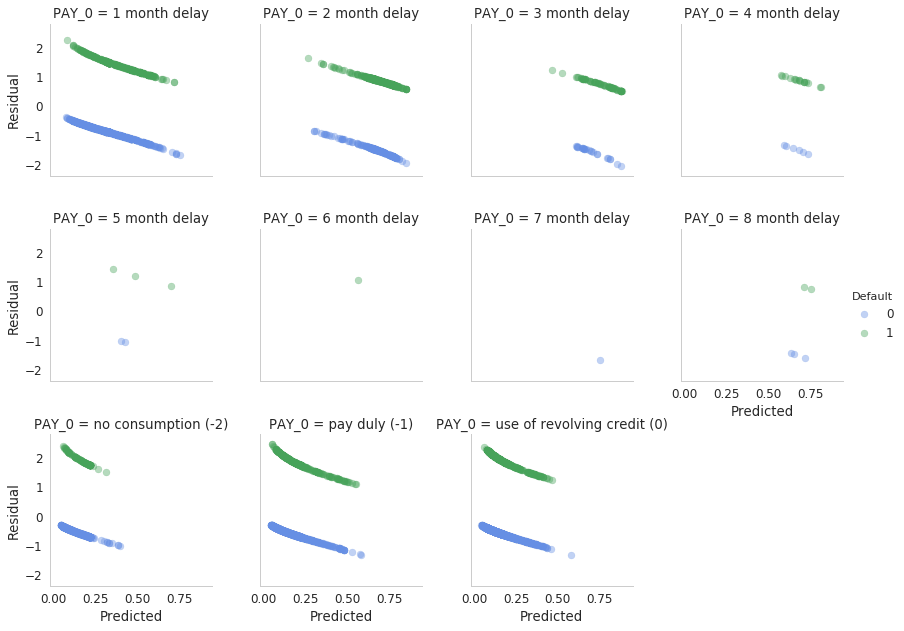

In [23]:
# sort for better organization in plot
sorted_ = test_yhat.sort_values(by='PAY_0')
sorted_.rename(columns={yhat: 'Predicted', 
                        'r_DEFAULT_NEXT_MONTH': 'Residual',
                        y: 'Default'}, 
               inplace=True)

# use Seaborn FacetGrid for convenience
sns.set(font_scale=1.2) 
sns.set_style('whitegrid', {'axes.grid': False})
sns.set_palette((sns.diverging_palette(255, 133, l=60, n=2, center='dark')))
g = sns.FacetGrid(sorted_, col='PAY_0', hue='Default', col_wrap=4)
_ = g.map(plt.scatter, 'Predicted', 'Residual', alpha=0.4)
_ = g.add_legend() 